In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
# from assets.Preprocessing import preprocess_image
from sklearn.preprocessing import MultiLabelBinarizer

masks = ['HardExudate_Masks', 'Hemohedge_Masks', 'Microaneurysms_Masks', 'SoftExudate_Masks']
mask_dir = '../data/Seg-set'
mask_paths = [os.path.join(mask_dir, mask) for mask in masks]


ex_file_list = os.listdir(mask_paths[0])
ex_paths = [os.path.join(mask_paths[0], file) for file in ex_file_list]
ex_paths.sort()

he_file_list = os.listdir(mask_paths[1])
he_paths = [os.path.join(mask_paths[1], file) for file in he_file_list]
he_paths.sort()

me_file_list = os.listdir(mask_paths[2])
me_paths = [os.path.join(mask_paths[2], file) for file in me_file_list]
me_paths.sort()

se_file_list = os.listdir(mask_paths[3])
se_paths = [os.path.join(mask_paths[3], file) for file in se_file_list]
se_paths.sort()

mask_images_paths = [list(_) for _ in zip(ex_paths, he_paths, me_paths, se_paths)]
        
image_dir = '../data/Seg-set/Original_Images'
image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir)]
image_paths.sort()

tr_image_paths = image_paths[:1290]
tr_mask_paths = mask_images_paths[:1290]

val_image_paths = image_paths[1290:1474]
val_mask_paths = mask_images_paths[1290:1474]

In [2]:
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 4

def crop_and_resize_image(image, img_size):
    resized_image = tf.image.resize(image, img_size)

    diameter = tf.minimum(tf.shape(resized_image)[0], tf.shape(resized_image)[1])
    center_x, center_y = tf.shape(resized_image)[1] // 2, tf.shape(resized_image)[0] // 2
    crop_size = tf.minimum(tf.minimum(center_x, center_y), diameter // 2)

    cropped_image = resized_image[
        center_y - crop_size:center_y + crop_size,
        center_x - crop_size:center_x + crop_size
    ]

    return cropped_image

def preprocess_image(image_path, img_size=(512, 512), use_hist=True):
    original_image = tf.io.read_file(image_path)
    original_image = tf.image.decode_jpeg(original_image, channels=3)

    if use_hist:
        seed = tf.constant([1, 2], dtype=tf.int32)
        clahe = tf.image.stateless_random_hue(original_image, max_delta=0.5, seed=seed)
        contrast_enhanced_image = tf.image.adjust_contrast(clahe, contrast_factor=2.0)
        cropped_image = crop_and_resize_image(contrast_enhanced_image, img_size)

        return cropped_image
    else:
        cropped_image = crop_and_resize_image(original_image, img_size)

        return cropped_image
    
def decode_image(img, channels=3):
    img = tf.image.decode_png(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    
    return img

def decode_label(label):
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    label -= 1
    
    return label

def load_and_preprocess_data(input_path, output_paths):
    image_path = input_path

    ex_path = output_paths[0]
    he_path = output_paths[1]
    me_path = output_paths[2]
    se_path = output_paths[3]
    
    
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = decode_image(image)
    image /= 255.0  # Normalize to [0, 1]

    # Read and preprocess the label
    ex = tf.io.read_file(ex_path)
    ex = decode_image(ex)
    # Convert to binary mask [0, 1] 
    ex = tf.cast(ex != 0, dtype=tf.float32)
    
#     he = tf.io.read_file(he_path)
#     he = decode_image(he)
#     # Convert to binary mask [0, 1] 
#     he = tf.cast(he != 0, dtype=tf.float32)
    
#     me = tf.io.read_file(me_path)
#     me = decode_image(me)
#     # Convert to binary mask [0, 1] 
#     me = tf.cast(me != 0, dtype=tf.float32)
    
#     se = tf.io.read_file(se_path)
#     se = decode_image(se)
#     # Convert to binary mask [0, 1] 
#     se = tf.cast(se != 0, dtype=tf.float32)
    
    return image, [ex]

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    ds = ds.repeat()
    
    return ds

tr_ds = tf.data.Dataset.from_tensor_slices((tr_image_paths, tr_mask_paths))
tr_ds = tr_ds.map(load_and_preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
tr_ds = prepare_for_training(tr_ds)

val_ds = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))
val_ds = val_ds.map(load_and_preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = prepare_for_training(val_ds)

In [4]:
# 결과 확인하기
# for image, labels in tr_ds.take(1):
#     print(image.shape)
#     print(labels[0][0].shape)
#     print(labels[0][1].shape)
    
# plt.imshow(image[0]*255)
# plt.show()
# plt.imshow(labels[0][0])
# plt.show()
# plt.imshow(labels[0][1])
# plt.show()

# for image, label in val_ds.take(1):
#     print(image.shape)
#     print(label.shape)
    
# plt.imshow(image[0]*255)
# plt.show()
# plt.imshow(label[0])
# plt.show()

In [5]:
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow import keras

class DiceScoreLossK(losses.Loss):
    def call(self, y_true, y_pred):
        smooth = 1.0
        
        numerator = 2. * K.sum(y_true * y_pred)
        denominator = K.sum(y_true + y_pred)
        
        return K.mean(1 - numerator / (denominator + smooth))

# mymodel.compile(loss=DiceScoreLossK(smooth=1.), ...)

In [6]:
def ConvBlock(x, n_filters):
    x = keras.layers.Conv2D(n_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(n_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    return x

def EncoderBlock(x, n_filters):
    p = ConvBlock(x, n_filters)
    x = keras.layers.MaxPooling2D(2)(p)
    
    return x, p

def DecoderBlock(x, n_filters, skip):
    x = keras.layers.Conv2DTranspose(n_filters, (2, 2), strides=2, padding='same')(x)
    x = keras.layers.Concatenate()([x, skip])
    x = ConvBlock(x, n_filters)
    
    return x

# Unet
# U-net
def UNET(img_size):
    inputs = keras.Input(shape=img_size + (3,))
    
    # 축소 경로
    skips = []
    
    filters = [64, 128, 256, 512, 1024]
    for f in filters:
        if f == 64:
            x, p = EncoderBlock(inputs, f)
            skips.append(p)
        else:
            x, p = EncoderBlock(x, f)
            skips.append(p)

    # 확장 경로
    for skip, f in zip(skips[::-1], filters[::-1]):
        if f == 1024:
            x_ex = DecoderBlock(x, f, skip)
            x_he = DecoderBlock(x, f, skip)
#             x_me = DecoderBlock(x, f, skip)
#             x_se = DecoderBlock(x, f, skip)
        else:
            x_ex = DecoderBlock(x_ex, f, skip)
#             x_he = DecoderBlock(x_he, f, skip)
#             x_me = DecoderBlock(x_me, f, skip)
#             x_se = DecoderBlock(x_se, f, skip)

    output_ex = keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid', name='output_ex')(x_ex)
#     output_he = keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid', name='output_he')(x_he)
#     output_me = keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid', name='output_me')(x_me)
#     output_se = keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid', name='output_se')(x_se)
    
    model = keras.Model(inputs, outputs=[output_ex])
    
    return model

In [11]:
losses = {
    "output_ex":DiceScoreLossK(),
#     "output_he":DiceScoreLossK(),
#     "output_me":DiceScoreLossK(),
#     "output_se":DiceScoreLossK()
}

model = UNET((512, 512))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 

model.compile(loss=losses, optimizer=optimizer)

In [12]:
# model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 512, 512, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 512, 512, 64) 256         conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 512, 512, 64) 0           batch_normalization_22[0][0]     
____________________________________________________________________________________________

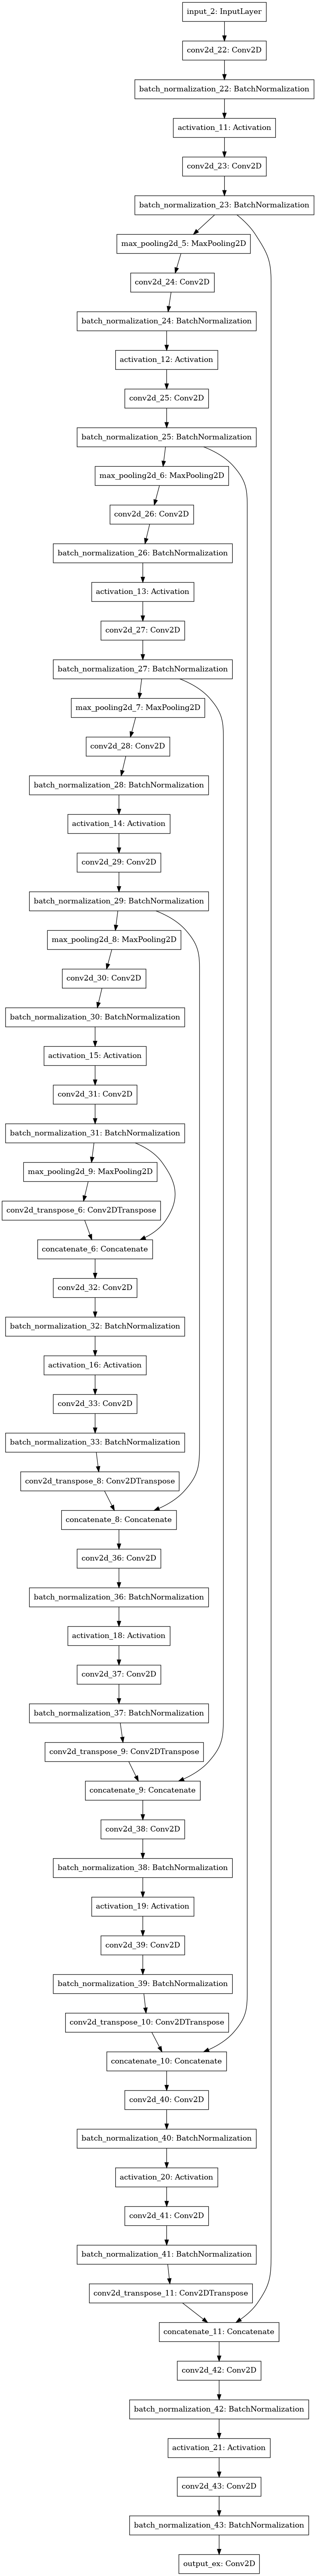

In [13]:
# keras.utils.plot_model(model)

In [ ]:
model.fit(tr_ds, 
          epochs=10, 
          steps_per_epoch=len(tr_image_paths) // BATCH_SIZE)

Epoch 1/10
322/322 [==============================] - 469s 1s/step - loss: 0.9732
Epoch 2/10
322/322 [==============================] - 433s 1s/step - loss: 0.9686
Epoch 3/10
322/322 [==============================] - 422s 1s/step - loss: 0.9669
Epoch 4/10
322/322 [==============================] - 423s 1s/step - loss: 0.9615
Epoch 5/10
  4/322 [..............................] - ETA: 5:18 - loss: 0.8970